In [ ]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 4.1 MB/s eta 0:00:00


In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import GPT2Tokenizer
from sklearn.model_selection import train_test_split
import nltk
from nltk.translate.bleu_score import corpus_bleu
from sacrebleu import corpus_chrf


nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
class TranslationDataset(Dataset):
    def __init__(self, source_sentences, target_sentences, tokenizer, max_len=128):
        self.source_sentences = source_sentences
        self.target_sentences = target_sentences
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.source_sentences)

    def __getitem__(self, idx):
        source = self.source_sentences[idx]
        target = self.target_sentences[idx]

        # Encode and handle padding
        source_tokens = self.tokenizer.encode(source, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')
        target_tokens = self.tokenizer.encode(target, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')

        return {'source': source_tokens.squeeze(0), 'target': target_tokens.squeeze(0)}


In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, max_length=128):
        super(Seq2Seq, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.encoder = nn.LSTM(embed_size, hidden_size, batch_first=True, bidirectional=True)

        self.decoder = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, vocab_size)

    def forward(self, src, tgt):

        embedded_src = self.embedding(src)
        _, (hidden, cell) = self.encoder(embedded_src)

        embedded_tgt = self.embedding(tgt)
        output, _ = self.decoder(embedded_tgt, (hidden, cell))


        output = self.fc(output)
        return output


In [ ]:
import json


with open('Hawaiian.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

english_sentences = []
hawaiian_sentences = []

for item in data[:50]:
    english_sentences.append(item['input'])
    hawaiian_sentences.append(item['output'])


In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.add_special_tokens({'pad_token': '[PAD]'})


train_en, val_en, train_hn, val_hn = train_test_split(english_sentences, hawaiian_sentences, test_size=0.2)


train_dataset = TranslationDataset(train_en, train_hn, tokenizer)
val_dataset = TranslationDataset(val_en, val_hn, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)


In [ ]:
def train_model(model, train_loader, val_loader, epochs=50, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)


    bleu_scores = []
    chrf_scores = []

    try:
        nltk.data.find('tokenizers/punkt_tab')
    except LookupError:
        nltk.download('punkt_tab')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            source = batch['source'].to(device)
            target = batch['target'].to(device)

            optimizer.zero_grad()
            output = model(source, target)
            output_dim = output.shape[-1]
            output = output.view(-1, output_dim)
            target = target.view(-1)

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for batch in val_loader:
                source = batch['source'].to(device)
                target = batch['target'].to(device)

                output = model(source, target)
                output_dim = output.shape[-1]
                output = output.view(-1, output_dim)
                target = target.view(-1)

                loss = criterion(output, target)
                val_loss += loss.item()

                preds = output.argmax(dim=-1)
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(target.cpu().numpy())

        # Calculate BLEU and chrF scores
        bleu = calculate_bleu(all_preds, all_targets)
        chrf = calculate_chrf(all_preds, all_targets)

        # Log results
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss/len(train_loader):.4f} | Validation Loss: {val_loss/len(val_loader):.4f} | BLEU: {bleu:.4f} | chrF: {chrf:.4f}")
        bleu_scores.append(bleu)
        chrf_scores.append(chrf)

    return bleu_scores, chrf_scores

def calculate_bleu(preds, targets):
    pred_sentences = tokenizer.batch_decode(preds, skip_special_tokens=True)
    target_sentences = tokenizer.batch_decode(targets, skip_special_tokens=True)
    pred_tokens = [nltk.word_tokenize(sentence) for sentence in pred_sentences]
    target_tokens = [[nltk.word_tokenize(sentence)] for sentence in target_sentences]
    return corpus_bleu(target_tokens, pred_tokens)

def calculate_chrf(preds, targets):
    pred_sentences = tokenizer.batch_decode(preds, skip_special_tokens=True)
    target_sentences = tokenizer.batch_decode(targets, skip_special_tokens=True)

    return corpus_chrf(target_sentences, pred_sentences)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


input_dim = len(tokenizer)
embedding_dim = 256
hidden_dim = 512
output_dim = len(tokenizer)


model = Seq2SeqModel(input_dim, embedding_dim, hidden_dim, output_dim).to(device)

bleu_scores, chrf_scores = train_model(model, train_loader, val_loader, epochs=50)


Epoch 1/50 | Train Loss: 8.0077 | Validation Loss: 6.5602 | BLEU: 0.0000 | chrF: 0.0079
Epoch 2/50 | Train Loss: 5.1729 | Validation Loss: 6.1159 | BLEU: 0.0000 | chrF: 0.0076
Epoch 3/50 | Train Loss: 4.8325 | Validation Loss: 5.7690 | BLEU: 0.0000 | chrF: 0.0076
Epoch 4/50 | Train Loss: 4.5921 | Validation Loss: 5.6889 | BLEU: 0.0000 | chrF: 0.0080
Epoch 5/50 | Train Loss: 4.6159 | Validation Loss: 5.7099 | BLEU: 0.0000 | chrF: 0.0077
Epoch 6/50 | Train Loss: 4.5232 | Validation Loss: 5.7290 | BLEU: 0.0000 | chrF: 0.0077
Epoch 7/50 | Train Loss: 4.4751 | Validation Loss: 5.7153 | BLEU: 0.0000 | chrF: 0.0079
Epoch 8/50 | Train Loss: 4.4819 | Validation Loss: 5.7380 | BLEU: 0.0000 | chrF: 0.0078
Epoch 9/50 | Train Loss: 4.4538 | Validation Loss: 5.7808 | BLEU: 0.0000 | chrF: 0.0078
Epoch 10/50 | Train Loss: 4.3576 | Validation Loss: 5.7741 | BLEU: 0.0000 | chrF: 0.0080
Epoch 11/50 | Train Loss: 4.3020 | Validation Loss: 5.8201 | BLEU: 0.0000 | chrF: 0.0077
Epoch 12/50 | Train Loss: 4.30

In [ ]:
def translate_sentence(model, sentence, tokenizer, max_len=128, reverse=False):
    tokens = tokenizer.encode(sentence, return_tensors='pt').to(device)
    if reverse:
        src, trg = tokens, tokens
    else:
        src, trg = tokens, tokens

    model.eval()
    with torch.no_grad():
        output = model(src, trg)
        output = output.argmax(dim=-1)

    translated_tokens = output.squeeze(0).cpu().numpy()


    translated_sentence = tokenizer.decode(translated_tokens, skip_special_tokens=True)
    return translated_sentence




In [ ]:
english_sentence = "This should be translated into something i want"
hawaiian_translation = translate_sentence(model, english_sentence, tokenizer, reverse=False)
print(f"English: {english_sentence}")
print(f"Hawaiian Translation: {hawaiian_translation}")


English: This should be translated into something i want
Hawaiian Translation: ālome��ana o�


In [ ]:
hawaiian_sentence = "Aloha oe"
english_translation = translate_sentence(model, hawaiian_sentence, tokenizer, reverse=True)
print(f"Hawaiian: {hawaiian_sentence}")
print(f"English Translation: {english_translation}")


Hawaiian: Aloha oe
English Translation:  � i i


In [ ]:
import csv

with open('scores.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Epoch', 'BLEU', 'chrF'])
    for epoch, (bleu, chrf) in enumerate(zip(bleu_scores, chrf_scores)):
        writer.writerow([epoch + 1, bleu, chrf])

In [ ]:
train_loss = [
    8.0077, 5.1729, 4.8325, 4.5921, 4.6159, 4.5232, 4.4751, 4.4819, 4.4538,
    4.3576, 4.3020, 4.3032, 4.2289, 4.1806, 4.0578, 3.9512, 3.8459, 3.7377,
    3.5704, 3.4777, 3.3644, 3.2684, 3.1742, 3.0669, 3.0130, 2.8428, 2.7908,
    2.7890, 2.6531, 2.8013, 2.6600, 2.6791, 2.5625, 2.5496, 2.6619, 2.5772,
    2.5616, 2.5279, 2.5597, 2.4717, 2.5487, 2.5148, 2.4878, 2.4169, 2.4806,
    2.3981, 2.5246, 2.5364, 2.4123, 2.4797
]

In [ ]:
val_loss = [
    6.5602, 6.1159, 5.7690, 5.6889, 5.7099, 5.7290, 5.7153, 5.7380, 5.7808,
    5.7741, 5.8201, 5.7724, 5.8742, 5.8202, 5.8620, 6.0217, 6.0132, 6.0084,
    6.2000, 6.2884, 6.3706, 6.4485, 6.4875, 6.7084, 6.7559, 6.8429, 7.0061,
    6.9220, 7.0435, 7.2118, 7.0605, 7.1734, 7.2896, 7.3055, 7.3008, 7.3452,
    7.3081, 7.3918, 7.5382, 7.4116, 7.5398, 7.4839, 7.4912, 7.5562, 7.6877,
    7.6425, 7.6074, 7.5859, 7.6440, 7.6387
]

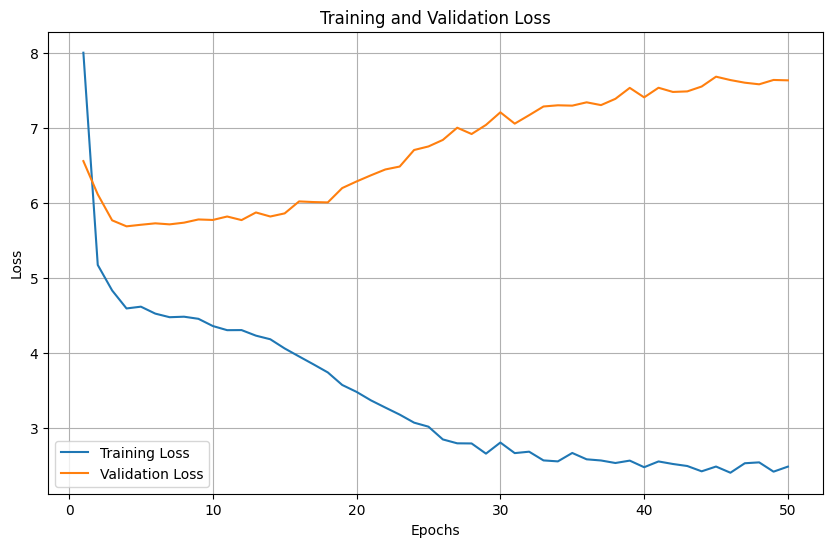

In [ ]:


import matplotlib.pyplot as plt


epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()